In [1]:
!pip install datasets scikit-learn xgboost


#  Imports and random seed

In [2]:
import numpy as np, pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

np.random.seed(42)


Load the Diabetes dataset and preview

In [4]:
ds = load_dataset("weeebdev/diabetes")
df = pd.DataFrame(ds["train"])
df.shape, df.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


diabetes.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/768 [00:00<?, ? examples/s]

((768, 9),
    Number of times pregnant  \
 0                         6   
 1                         1   
 2                         8   
 3                         1   
 4                         0   
 
    Plasma glucose concentration a 2 hours in an oral glucose tolerance test  \
 0                                                148                          
 1                                                 85                          
 2                                                183                          
 3                                                 89                          
 4                                                137                          
 
    Diastolic blood pressure (mm Hg)  Triceps skin fold thickness (mm)  \
 0                                72                                35   
 1                                66                                29   
 2                                64                                 0   
 3               

Basic inspection

In [5]:
df.info()
df.isna().sum()
df["Class variable"].value_counts(), df["Class variable"].value_counts(normalize=True).round(3)
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Number of times pregnant                                                  768 non-null    int64  
 1   Plasma glucose concentration a 2 hours in an oral glucose tolerance test  768 non-null    int64  
 2   Diastolic blood pressure (mm Hg)                                          768 non-null    int64  
 3   Triceps skin fold thickness (mm)                                          768 non-null    int64  
 4   2-Hour serum insulin (mu U/ml)                                            768 non-null    int64  
 5   Body mass index (weight in kg/(height in m)^2)                            768 non-null    float64
 6   Diabetes pedigree function                                         

,count,mean,std,min,25%,50%,75%,max
Number of times pregnant,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Plasma glucose concentration a 2 hours in an oral glucose tolerance test,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
Diastolic blood pressure (mm Hg),768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
Triceps skin fold thickness (mm),768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
2-Hour serum insulin (mu U/ml),768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
Body mass index (weight in kg/(height in m)^2),768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
Diabetes pedigree function,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age (years),768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class variable,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
import numpy as np

# Columns where 0 should be considered missing
cols_with_missing = [
    'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
    'Diastolic blood pressure (mm Hg)',
    'Triceps skin fold thickness (mm)',
    '2-Hour serum insulin (mu U/ml)',
    'Body mass index (weight in kg/(height in m)^2)'
]

# Replace zeros with NaN
df[cols_with_missing] = df[cols_with_missing].replace(0, np.nan)

# Fill missing values with median of each column
for col in cols_with_missing:
    df[col] = df[col].fillna(df[col].median())

# Check if any NaNs remain
df[cols_with_missing].isnull().sum()


,0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test,0
Diastolic blood pressure (mm Hg),0
Triceps skin fold thickness (mm),0
2-Hour serum insulin (mu U/ml),0
Body mass index (weight in kg/(height in m)^2),0


Set up features/target

In [7]:
y = df["Class variable"].astype(int)
X = df.drop(columns=["Class variable"])
X.shape, y.shape, y.value_counts().to_dict()


((768, 8), (768,), {0: 500, 1: 268})

Train/Validation/Test Split
We split the dataset into:
- 70% training
- 15% validation
- 15% test  
We also define a StratifiedKFold object for cross-validation to preserve class balance.


In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Split temp into 50% validation, 50% test → 15% each
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Define stratified 5-fold CV for later
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train.shape, X_valid.shape, X_test.shape



((537, 8), (115, 8), (116, 8))

###  Feature Scaling
We scale all numeric features using StandardScaler.
The scaler is fit only on the training set to avoid data leakage.


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training, transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


### Validation evaluation helper
Compute accuracy, precision, recall, F1, and confusion matrix for any fitted model.


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def eval_on_valid(name, model, Xv, yv):
    yp = model.predict(Xv)
    acc = accuracy_score(yv, yp)
    pr, rc, f1, _ = precision_recall_fscore_support(yv, yp, average="binary", zero_division=0)
    cm = confusion_matrix(yv, yp)
    return {"model": name, "accuracy": acc, "precision": pr, "recall": rc, "f1": f1, "cm": cm}


### SVM (RBF) with small grid (uses scaled data)
We use 5-fold Stratified CV on the training set, then evaluate once on the validation set.


In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

svm_rbf = Pipeline([("svc", SVC())])
svm_rbf_grid = {"svc__kernel":["rbf"], "svc__C":[0.1,1,10], "svc__gamma":["scale","auto"]}

svm_rbf_gs = GridSearchCV(svm_rbf, svm_rbf_grid, cv=cv, scoring="f1", n_jobs=-1)
svm_rbf_gs.fit(X_train_scaled, y_train)

svm_rbf_res = eval_on_valid("svm_rbf", svm_rbf_gs.best_estimator_, X_valid_scaled, y_valid)
svm_rbf_res


{'model': 'svm_rbf',
 'accuracy': 0.7478260869565218,
 'precision': 0.6571428571428571,
 'recall': 0.575,
 'f1': 0.6133333333333333,
 'cm': array([[63, 12],
        [17, 23]])}

###  SVM (Linear, Poly, Sigmoid)
Test other kernels with small hyperparameter grids.


In [13]:
svm_kernels = {
    "svm_linear": {"svc__kernel": ["linear"], "svc__C": [0.1, 1, 10]},
    "svm_poly": {"svc__kernel": ["poly"], "svc__degree": [2, 3], "svc__C": [0.1, 1]},
    "svm_sigmoid": {"svc__kernel": ["sigmoid"], "svc__C": [0.1, 1, 10]}
}

svm_results = []
for name, grid in svm_kernels.items():
    model = Pipeline([("svc", SVC())])
    gs = GridSearchCV(model, grid, cv=cv, scoring="f1", n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    res = eval_on_valid(name, gs.best_estimator_, X_valid_scaled, y_valid)
    svm_results.append(res)

svm_results


[{'model': 'svm_linear',
  'accuracy': 0.7043478260869566,
  'precision': 0.5882352941176471,
  'recall': 0.5,
  'f1': 0.5405405405405406,
  'cm': array([[61, 14],
         [20, 20]])},
 {'model': 'svm_poly',
  'accuracy': 0.7130434782608696,
  'precision': 0.6666666666666666,
  'recall': 0.35,
  'f1': 0.45901639344262296,
  'cm': array([[68,  7],
         [26, 14]])},
 {'model': 'svm_sigmoid',
  'accuracy': 0.7217391304347827,
  'precision': 0.6111111111111112,
  'recall': 0.55,
  'f1': 0.5789473684210527,
  'cm': array([[61, 14],
         [18, 22]])}]

### Decision Tree Classifier
Train and tune key parameters like max_depth and min_samples_split.


In [14]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    "clf__max_depth": [3, 5, 7, None],
    "clf__min_samples_split": [2, 5, 10]
}

dt_pipeline = Pipeline([("clf", DecisionTreeClassifier(random_state=42))])

dt_gs = GridSearchCV(dt_pipeline, dt_params, cv=cv, scoring="f1", n_jobs=-1)
dt_gs.fit(X_train_scaled, y_train)

dt_result = eval_on_valid("decision_tree", dt_gs.best_estimator_, X_valid_scaled, y_valid)
dt_result


{'model': 'decision_tree',
 'accuracy': 0.7043478260869566,
 'precision': 0.59375,
 'recall': 0.475,
 'f1': 0.5277777777777778,
 'cm': array([[62, 13],
        [21, 19]])}

###  Random Forest Classifier
Train and tune parameters like number of trees (n_estimators) and max_depth.


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 5, 10]
}

rf_pipeline = Pipeline([("clf", RandomForestClassifier(random_state=42))])

rf_gs = GridSearchCV(rf_pipeline, rf_params, cv=cv, scoring="f1", n_jobs=-1)
rf_gs.fit(X_train_scaled, y_train)

rf_result = eval_on_valid("random_forest", rf_gs.best_estimator_, X_valid_scaled, y_valid)
rf_result


{'model': 'random_forest',
 'accuracy': 0.7391304347826086,
 'precision': 0.6388888888888888,
 'recall': 0.575,
 'f1': 0.6052631578947368,
 'cm': array([[62, 13],
        [17, 23]])}

###  XGBoost Classifier
Train using XGBClassifier and tune parameters like learning_rate and max_depth.


In [16]:
from xgboost import XGBClassifier

xgb_params = {
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__max_depth": [3, 5, 7],
    "clf__n_estimators": [50, 100, 200]
}

xgb_pipeline = Pipeline([("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))])

xgb_gs = GridSearchCV(xgb_pipeline, xgb_params, cv=cv, scoring="f1", n_jobs=-1)
xgb_gs.fit(X_train_scaled, y_train)

xgb_result = eval_on_valid("xgboost", xgb_gs.best_estimator_, X_valid_scaled, y_valid)
xgb_result


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:21:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'model': 'xgboost',
 'accuracy': 0.7565217391304347,
 'precision': 0.6666666666666666,
 'recall': 0.6,
 'f1': 0.631578947368421,
 'cm': array([[63, 12],
        [16, 24]])}

###  k-Nearest Neighbors Classifier
Train using KNeighborsClassifier and tune parameters like n_neighbors and weights.


In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    "clf__n_neighbors": [3, 5, 7, 9],
    "clf__weights": ["uniform", "distance"]
}

knn_pipeline = Pipeline([("clf", KNeighborsClassifier())])

knn_gs = GridSearchCV(knn_pipeline, knn_params, cv=cv, scoring="f1", n_jobs=-1)
knn_gs.fit(X_train_scaled, y_train)

knn_result = eval_on_valid("k-NN", knn_gs.best_estimator_, X_valid_scaled, y_valid)
knn_result


{'model': 'k-NN',
 'accuracy': 0.7652173913043478,
 'precision': 0.6666666666666666,
 'recall': 0.65,
 'f1': 0.6582278481012658,
 'cm': array([[62, 13],
        [14, 26]])}

###  Logistic Regression
Train using LogisticRegression and tune parameters like C (regularization) and solver.


In [18]:
from sklearn.linear_model import LogisticRegression

log_params = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"]
}

log_pipeline = Pipeline([("clf", LogisticRegression(max_iter=1000))])

log_gs = GridSearchCV(log_pipeline, log_params, cv=cv, scoring="f1", n_jobs=-1)
log_gs.fit(X_train_scaled, y_train)

log_result = eval_on_valid("Logistic Regression", log_gs.best_estimator_, X_valid_scaled, y_valid)
log_result


{'model': 'Logistic Regression',
 'accuracy': 0.7130434782608696,
 'precision': 0.5945945945945946,
 'recall': 0.55,
 'f1': 0.5714285714285714,
 'cm': array([[60, 15],
        [18, 22]])}

In [19]:
import pandas as pd

# Combine all results into a list of dictionaries
results = [
    {'Model': 'SVM (Linear)', 'Accuracy': 0.7043, 'Precision': 0.5882, 'Recall': 0.50, 'F1-score': 0.5405},
    {'Model': 'SVM (Poly)', 'Accuracy': 0.7130, 'Precision': 0.6667, 'Recall': 0.35, 'F1-score': 0.4590},
    {'Model': 'SVM (Sigmoid)', 'Accuracy': 0.7217, 'Precision': 0.6111, 'Recall': 0.55, 'F1-score': 0.5789},
    {'Model': 'SVM (RBF)', 'Accuracy': 0.7478, 'Precision': 0.6571, 'Recall': 0.575, 'F1-score': 0.6133},
    {'Model': 'Decision Tree', 'Accuracy': 0.7043, 'Precision': 0.5938, 'Recall': 0.475, 'F1-score': 0.5278},
    {'Model': 'Random Forest', 'Accuracy': 0.7391, 'Precision': 0.6389, 'Recall': 0.575, 'F1-score': 0.6053},
    {'Model': 'XGBoost', 'Accuracy': 0.7565, 'Precision': 0.6667, 'Recall': 0.60, 'F1-score': 0.6316},
    {'Model': 'k-NN', 'Accuracy': 0.7652, 'Precision': 0.6667, 'Recall': 0.65, 'F1-score': 0.6582},
    {'Model': 'Logistic Regression', 'Accuracy': 0.7130, 'Precision': 0.5946, 'Recall': 0.55, 'F1-score': 0.5714}
]

# Create DataFrame
df_results = pd.DataFrame(results)

# Display sorted by Accuracy
df_results.sort_values(by='Accuracy', ascending=False)


,Model,Accuracy,Precision,Recall,F1-score
7,k-NN,0.7652,0.6667,0.650,0.6582
6,XGBoost,0.7565,0.6667,0.600,0.6316
3,SVM (RBF),0.7478,0.6571,0.575,0.6133
5,Random Forest,0.7391,0.6389,0.575,0.6053
2,SVM (Sigmoid),0.7217,0.6111,0.550,0.5789
8,Logistic Regression,0.7130,0.5946,0.550,0.5714
1,SVM (Poly),0.7130,0.6667,0.350,0.4590
0,SVM (Linear),0.7043,0.5882,0.500,0.5405
4,Decision Tree,0.7043,0.5938,0.475,0.5278


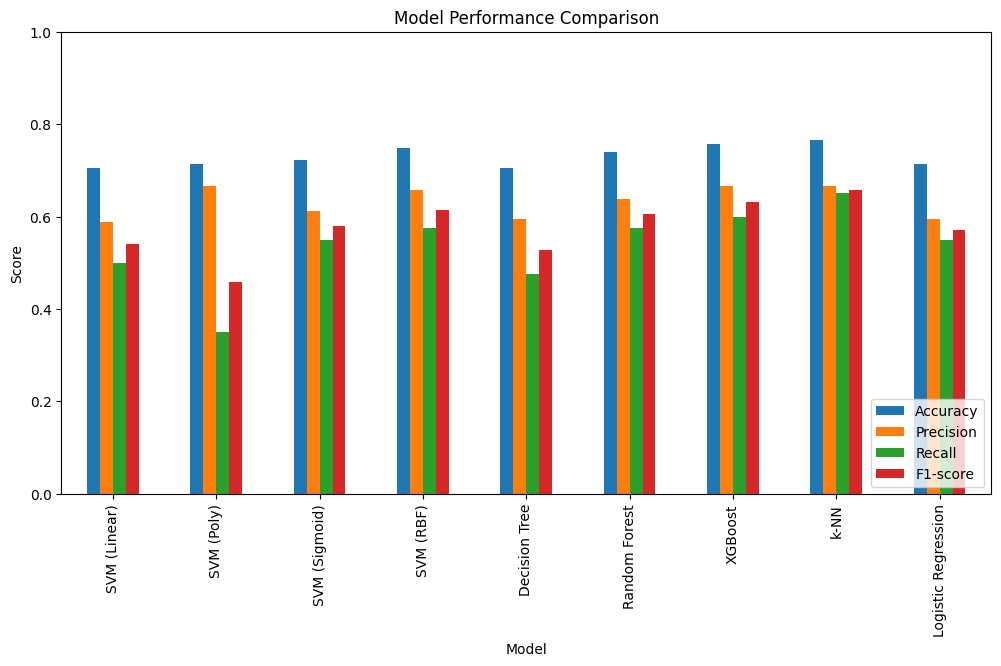

In [20]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
df_results.set_index('Model')[metrics].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()


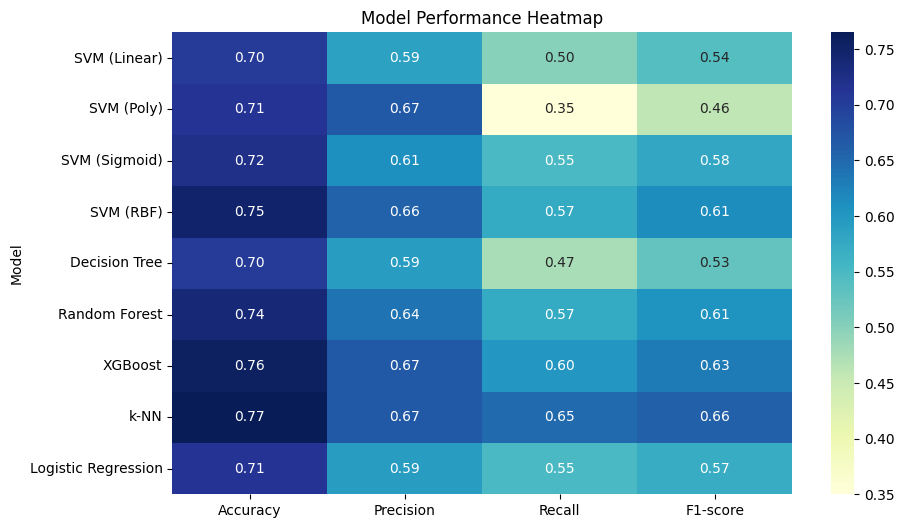

In [21]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(df_results.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-score']],
            annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Model Performance Heatmap')
plt.show()


In [24]:

df_results.to_csv("task3_results.csv", index=False)

from google.colab import files
files.download("task3_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>